## 0. Import the Libraries

In [1]:
import pickle
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from datetime import datetime
from collections import Counter
import itertools
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

from sklearn.model_selection import GridSearchCV
from sklearn import datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from imblearn.combine import SMOTEENN

# plotly.tools.set_credentials_file(username='', api_key='')

/Users/babak/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## 1. Download, Load and Prepare Data

### Download and merge dataset

In [44]:
df_17 = pd.read_csv("Crimes_-_2017.csv")

In [45]:
df_18 = pd.read_csv("Crimes_-_2018.csv")

In [46]:
df_17_n_18= df_17.append(df_18, ignore_index=True)

In [118]:
df_17_n_18.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [52]:
selected_columns = ['Date', 'Latitude', 'Longitude', 'Arrest']
df = df_17_n_18[selected_columns]

In [55]:
df.head()

,Date,Latitude,Longitude,Arrest
0,09/21/2017 12:15:00 AM,42.012293,-87.699714,True
1,10/12/2017 07:14:00 PM,41.918712,-87.765511,True
2,10/30/2017 11:52:00 AM,41.814670,-87.690727,True
3,09/29/2017 06:45:00 PM,41.938581,-87.765831,True
4,12/01/2017 06:20:00 AM,41.895805,-87.683159,True


In [56]:
print("{:,} total crime records".format(len(df)))

350,205 total crime records


### Drop the duplicates

In [57]:
df = df.drop_duplicates()
print("{:,} total crime records after removing duplicates".format(len(df)))

347,192 total crime records after removing duplicates


### Break up date into components

In [58]:
def break_up_date(str_date):
    date_format = '%m/%d/%Y %I:%M:%S %p'
    date = datetime.strptime(str_date, date_format)
    return date

years = []
months = []
days = []
hours = []
minutes = []
for date in map(break_up_date,df['Date']):
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    hours.append(date.hour)
    minutes.append(date.minute)
df['Year'] = years
df['Month'] = months
df['Day'] =  days
df['Hour'] = hours
df['Minute'] = minutes

In [59]:
df.drop('Date',axis=1,inplace=True)

### Drop NA values

In [60]:
df.dropna(axis=0,how='any', inplace=True)
print("{:,} total crime records after removing NAs".format(len(df)))

345,037 total crime records after removing NAs


In [61]:
df.head()

,Latitude,Longitude,Arrest,Year,Month,Day,Hour,Minute
0,42.012293,-87.699714,True,2017,9,21,0,15
1,41.918712,-87.765511,True,2017,10,12,19,14
2,41.814670,-87.690727,True,2017,10,30,11,52
3,41.938581,-87.765831,True,2017,9,29,18,45
4,41.895805,-87.683159,True,2017,12,1,6,20


In [109]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Latitude,345037.0,41.844300,0.086064,41.644606,41.769453,41.865147,41.906230,42.022671
Longitude,345037.0,-87.670364,0.058767,-87.934273,-87.712608,-87.664047,-87.627761,-87.524529
Year,345037.0,2017.237664,0.425653,2017.000000,2017.000000,2017.000000,2017.000000,2018.000000
Month,345037.0,5.628976,3.424839,1.000000,3.000000,5.000000,8.000000,12.000000
Day,345037.0,15.524660,8.839743,1.000000,8.000000,16.000000,23.000000,31.000000
Hour,345037.0,13.197715,6.476026,0.000000,9.000000,14.000000,18.000000,23.000000
Minute,345037.0,19.880923,18.540425,0.000000,0.000000,18.000000,32.000000,59.000000


<Figure size 3000x2000 with 0 Axes>

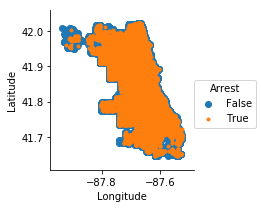

In [71]:
plt.figure(dpi=500)
sns.FacetGrid(df, hue="Arrest",hue_kws=dict(marker=["o", "."])).map(plt.scatter,"Longitude","Latitude").add_legend()
plt.show()

### Convert df data to array type

In [72]:
y = np.asarray(df[['Arrest']])
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

X = df[['Latitude','Longitude','Month','Day','Hour','Minute']]
X = X.to_dict(orient='records')
vec = DictVectorizer()
X = vec.fit_transform(X).toarray()

/Users/babak/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/babak/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Balancing data

In [73]:
print("Count of each target from unbalanced dataset: {} (arrest true (1) or false (0))".format(sorted(Counter(y).items())))
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X, y)
print("Count of each target from balanced dataset: {} (arrest true (1) or false (0))".format(sorted(Counter(y_resampled).items())))

Count of each target from unbalanced dataset: [(0, 276961), (1, 68076)] (arrest true (1) or false (0))
Count of each target from balanced dataset: [(0, 152402), (1, 177501)] (arrest true (1) or false (0))


### Split data into train and test set

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.2, random_state=42)

### Normalize the input features

In [75]:
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

## 2. Grid Search Modeling, Prediction and Evaluation

### Logistic Regression

In [70]:
parameters = { 
    'C': np.power(10.0, np.arange(-10, 10)),
    'solver': ['newton-cg','lbfgs','saga'],
    'class_weight' : ['balanced','dict']
}
lr = LogisticRegression();
grid_lr = GridSearchCV(estimator=lr,param_grid=parameters, verbose=0);
grid_lr.fit(X_train, y_train);

In [71]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)
# print(grid_lr.feature_importances_)

{'C': 1e-05, 'solver': 'saga', 'class_weight': 'dict'}
0.71687847166966
LogisticRegression(C=1e-05, class_weight='dict', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)


{'C': 1e-05, 'solver': 'saga', 'class_weight': 'dict'}
0.71687847166966
LogisticRegression(C=1e-05, class_weight='dict', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [72]:
grid_lr.best_estimator_.fit(X_train, y_train);

In [92]:
%%timeit
lr = LogisticRegression(C=1e-05, class_weight='dict', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False);
lr.fit(X_train2,y_train)

1.76 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%%timeit
lr_expected = y_test
lr_predicted = lr.predict(X_test)
lr_cm = metrics.confusion_matrix(lr_expected, lr_predicted)

print("Accuracy={}".format(metrics.accuracy_score(lr_expected, lr_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(lr_expected, lr_predicted)))
print("Confusion matrix:\n%s" % lr_cm)

Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     6598

/Users/babak/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     6598

Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     6598

Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     6598

Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     65981


Confusion matrix:
[[    0 30429]
 [    0 35552]]
Accuracy=0.5388217820281597
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     30429
          1       0.54      1.00      0.70     35552

avg / total       0.29      0.54      0.38     6598

Confusion matrix, without normalization
[[18831 11598]
 [ 7958 27594]]


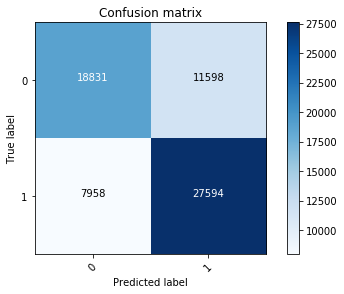

In [74]:
plot_confusion_matrix(lr_cm,classes=[0,1],cmap=plt.cm.Blues)
plt.show()

### K-Nearest Neighbors

In [77]:
parameters = { 
    'n_neighbors':[5,7,9],
    'weights':['uniform', 'distance']
}
knn = KNeighborsClassifier();
grid_knn = GridSearchCV(estimator=knn, param_grid=parameters, verbose=0);
grid_knn.fit(X_train, y_train);

In [78]:
print(grid_knn.best_params_)
print(grid_knn.best_score_)
print(grid_knn.best_estimator_)
# print(grid_lr.feature_importances_)

{'n_neighbors': 5, 'weights': 'distance'}
0.8260319336773744
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')


{'n_neighbors': 5, 'weights': 'distance'}
0.8260319336773744
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [79]:
grid_knn.best_estimator_.fit(X_train, y_train);

In [93]:
%%timeit
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance');
knn.fit(X_train2,y_train)

391 ms ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
%%timeit
knn_expected = y_test
knn_predicted = knn.predict(X_test)
knn_cm = metrics.confusion_matrix(knn_expected, knn_predicted)

print("Accuracy={}".format(metrics.accuracy_score(knn_expected, knn_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(knn_expected, knn_predicted)))
print("Confusion matrix:\n%s" % knn_cm)

Accuracy=0.5698610205968385
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.52      0.91      0.66     30429
          1       0.78      0.28      0.41     35552

avg / total       0.66      0.57      0.53     65981


Confusion matrix:
[[27587  2842]
 [25539 10013]]
Accuracy=0.5698610205968385
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.52      0.91      0.66     30429
          1       0.78      0.28      0.41     35552

avg / total       0.66      0.57      0.53     65981


Confusion matrix:
[[27587  2842]
 [25539 10013]]
Accuracy=0.5698610205968385
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.52      0.91      0.66     30429
          1       0.78      0.28      0.41     35552

avg / total       0.66      0.57      0.53     6598

Confusion matrix, without normalization
[[23406  7023]
 [ 3371 32181]]


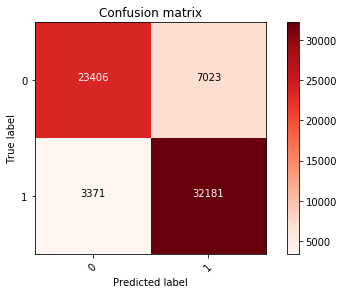

In [85]:
plot_confusion_matrix(knn_cm,classes=[0,1],cmap=plt.cm.Reds)
plt.show()

### Decision Tree

In [84]:
parameters = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2,4,5,6,7,8,9,10], 
    'min_samples_leaf':[2,4,6,8,10]
}
dt = DecisionTreeClassifier();
dt_start_time = datetime.now()
print('Start learning at {}'.format(str(dt_start_time)))
grid_dt = GridSearchCV(estimator=dt, param_grid=parameters, verbose=0);
grid_dt.fit(X_train, y_train);
dt_end_time = datetime.now() 
print('Stop learning {}'.format(str(dt_end_time)))
dt_elapsed_time= dt_end_time - dt_start_time
print('Elapsed learning {}'.format(str(dt_elapsed_time)))

Start learning at 2018-05-16 00:59:13.654172
Stop learning 2018-05-16 01:01:56.116951
Elapsed learning 0:02:42.462779


In [86]:
print(grid_dt.best_params_)
print(grid_dt.best_score_)
print(grid_dt.best_estimator_)
# print(grid_lr.feature_importances_)

{'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 10}
0.8439008494934109
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


{'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 10}
0.8439008494934109
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [87]:
grid_dt.best_estimator_.fit(X_train, y_train);

In [94]:
dt_expected = y_test
dt_start_time_test = datetime.now()
print('Start testing at {}'.format(str(dt_start_time_test)))
dt_predicted = grid_dt.best_estimator_.predict(X_test)
dt_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(dt_end_time_test)))
dt_elapsed_time_test = dt_end_time_test - dt_start_time_test
print('Elapsed testing {}'.format(str(dt_elapsed_time_test)))
dt_cm = metrics.confusion_matrix(dt_expected, dt_predicted)

Start testing at 2018-05-16 02:03:44.378678
Stop testing 2018-05-16 02:03:44.393305
Elapsed testing 0:00:00.014627


In [89]:
print("Accuracy={}".format(metrics.accuracy_score(dt_expected, dt_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(dt_expected, dt_predicted)))
print("Confusion matrix:\n%s" % dt_cm)

Accuracy=0.842318243131
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.83      0.83      0.83     30429
          1       0.86      0.85      0.85     35552

avg / total       0.84      0.84      0.84     65981


Confusion matrix:
[[23406  7023]
 [ 3371 32181]]


Confusion matrix, without normalization
[[23406  7023]
 [ 3371 32181]]


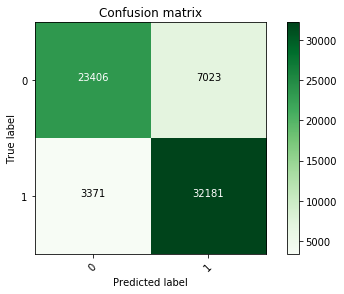

In [91]:
plot_confusion_matrix(dt_cm,classes=[0,1],cmap=plt.cm.Greens)
plt.show()

### Random Forest

In [93]:
parameters = { 
    'criterion':['gini','entropy'],
    'n_estimators':[10,15,20,25,30],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[3,4,5,6,7]
}
rf = RandomForestClassifier();
rf_start_time = datetime.now()
print('Start learning at {}'.format(str(rf_start_time)))
grid_rf = GridSearchCV(estimator=rf, param_grid=parameters, verbose=0);
grid_rf.fit(X_train, y_train);
rf_end_time = datetime.now() 
print('Stop learning {}'.format(str(rf_end_time)))
rf_elapsed_time= rf_end_time - rf_start_time
print('Elapsed learning {}'.format(str(rf_elapsed_time)))

Start learning at 2018-05-16 01:08:49.611455
Stop learning 2018-05-16 02:03:44.364974
Elapsed learning 0:54:54.753519


In [96]:
print(grid_rf.best_params_)
print(grid_rf.best_score_)
print(grid_rf.best_estimator_)
# print(grid_lr.feature_importances_)

{'min_samples_split': 3, 'n_estimators': 30, 'criterion': 'entropy', 'min_samples_leaf': 1}
0.8902630322595312
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


{'min_samples_split': 3, 'n_estimators': 30, 'criterion': 'entropy', 'min_samples_leaf': 1}
0.8902630322595312
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [97]:
grid_rf.best_estimator_.fit(X_train, y_train);

In [98]:
rf_expected = y_test
rf_start_time_test = datetime.now()
print('Start testing at {}'.format(str(rf_start_time_test)))
rf_predicted = grid_rf.best_estimator_.predict(X_test)
rf_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(rf_end_time_test)))
rf_elapsed_time_test = rf_end_time_test - rf_start_time_test
print('Elapsed testing {}'.format(str(rf_elapsed_time_test)))
rf_cm = metrics.confusion_matrix(rf_expected, rf_predicted)

Start testing at 2018-05-16 05:06:44.708352
Stop testing 2018-05-16 05:06:45.218685
Elapsed testing 0:00:00.510333


In [99]:
print("Accuracy={}".format(metrics.accuracy_score(rf_expected, rf_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(rf_expected, rf_predicted)))
print("Confusion matrix:\n%s" % rf_cm)

Accuracy=0.899652930389
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.91      0.87      0.89     30429
          1       0.89      0.92      0.91     35552

avg / total       0.90      0.90      0.90     65981


Confusion matrix:
[[26522  3907]
 [ 2714 32838]]


Confusion matrix, without normalization
[[26522  3907]
 [ 2714 32838]]


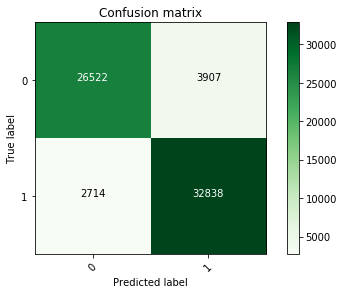

In [100]:
plot_confusion_matrix(rf_cm,classes=[0,1],cmap=plt.cm.Greens)
plt.show()

### XG-Boost

In [76]:
from xgboost import XGBClassifier

In [104]:
parameters = { 
    'max_depth' : [10],
    'n_estimators': [100,200],
    'booster': ['gbtree']
}
xgb = XGBClassifier();
xgb_start_time = datetime.now()
print('Start learning at {}'.format(str(xgb_start_time)))
grid_xgb = GridSearchCV(estimator=xgb, param_grid=parameters, verbose=0);
grid_xgb.fit(X_train, y_train);
xgb_end_time = datetime.now() 
print('Stop learning {}'.format(str(xgb_end_time)))
xgb_elapsed_time= xgb_end_time - xgb_start_time
print('Elapsed learning {}'.format(str(xgb_elapsed_time)))

Start learning at 2018-05-16 05:24:07.454227


/Users/Babak/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/Babak/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/Babak/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/Users/Babak/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but

Stop learning 2018-05-16 05:28:51.165714
Elapsed learning 0:04:43.711487


In [105]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)
print(grid_xgb.best_estimator_)
# print(grid_xgb.feature_importances_)

{'n_estimators': 200, 'max_depth': 10, 'booster': 'gbtree'}
0.9251559172785899
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


{'n_estimators': 200, 'max_depth': 10, 'booster': 'gbtree'}
0.9251559172785899
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [106]:
grid_xgb.best_estimator_.fit(X_train2, y_train2);

In [94]:
xgb = XGBClassifier(n_estimators=200,max_depth=10,booster='gbtree');
xgb.fit(X_train2, y_train);
xgb_expected = y_test
xgb_predicted = xgb.predict(X_test2)
xgb_cm = metrics.confusion_matrix(xgb_expected, xgb_predicted)

/Users/babak/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [99]:
xgb_expected = y_test
xgb_start_time_test = datetime.now()
print('Start testing at {}'.format(str(xgb_start_time_test)))
xgb_predicted = xgb.predict(X_test2)
xgb_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(xgb_end_time_test)))
xgb_elapsed_time_test = xgb_end_time_test - xgb_start_time_test
print('Elapsed testing {}'.format(str(xgb_elapsed_time_test)))
xgb_cm = metrics.confusion_matrix(xgb_expected, xgb_predicted)

Start testing at 2018-05-17 02:52:50.724690
Stop testing 2018-05-17 02:52:52.038249
Elapsed testing 0:00:01.313559


/Users/babak/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [119]:
print("Accuracy={}".format(metrics.accuracy_score(xgb_expected, xgb_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("XG-Boost", metrics.classification_report(xgb_expected, xgb_predicted)))
print("Confusion matrix:\n%s" % xgb_cm)

Accuracy=0.9284794107394553
Classification report for classifier XG-Boost:
             precision    recall  f1-score   support

          0       0.92      0.92      0.92     30429
          1       0.93      0.94      0.93     35552

avg / total       0.93      0.93      0.93     65981


Confusion matrix:
[[28004  2425]
 [ 2294 33258]]


Normalized confusion matrix
[[0.92030629 0.07969371]
 [0.0645252  0.9354748 ]]


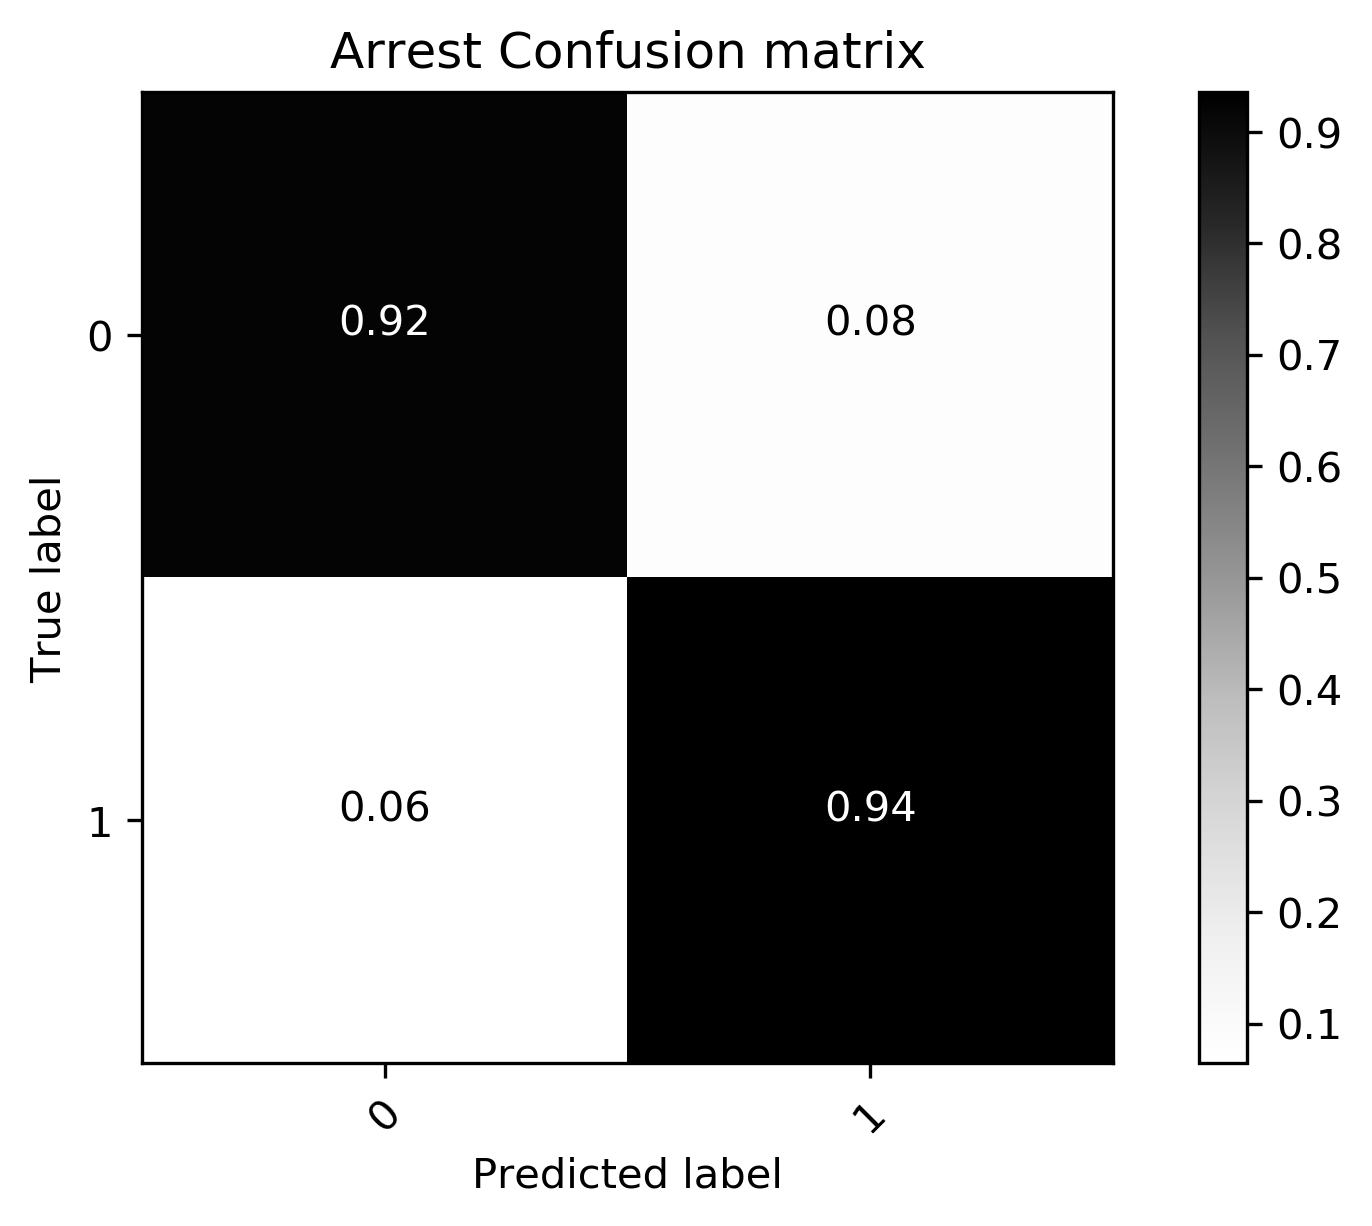

In [107]:
plt.figure(dpi=300)
plot_confusion_matrix(xgb_cm,classes=[0,1],cmap=plt.cm.Greys,normalize=True)
plt.show()

### Support Vector Machine

In [ ]:
# parameters = { 
#     'C': [6], 
#     'kernel': ['linear','rbf']
# }
# svm = SVC();
# svm_start_time = datetime.now()
# print('Start learning at {}'.format(str(svm_start_time)))
# grid_svm = GridSearchCV(estimator=svm, param_grid=parameters, verbose=0);
# grid_svm.fit(X_train, y_train);
# svm_end_time = datetime.now() 
# print('Stop learning {}'.format(str(svm_end_time)))
# svm_elapsed_time= svm_end_time - svm_start_time
# print('Elapsed learning {}'.format(str(svm_elapsed_time)))

Start learning at 2018-05-16 05:36:13.393840


In [ ]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)
print(grid_svm.best_estimator_)
# print(grid_xgb.feature_importances_)

In [ ]:
grid_svm.best_estimator_.fit(X_train, y_train);

In [ ]:
svm_expected = y_test
svm_start_time_test = datetime.now()
print('Start testing at {}'.format(str(svm_start_time_test)))
svm_predicted = grid_svm.best_estimator_.predict(X_test)
svm_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(svm_end_time_test)))
svm_elapsed_time_test = svm_end_time_test - svm_start_time_test
print('Elapsed testing {}'.format(str(svm_elapsed_time_test)))
svm_cm = metrics.confusion_matrix(svm_expected, svm_predicted)

In [ ]:
print("Accuracy={}".format(metrics.accuracy_score(svm_expected, svm_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(svm_expected, svm_predicted)))
print("Confusion matrix:\n%s" % svm_cm)

In [ ]:
plot_confusion_matrix(svm_cm,classes=[0,1],cmap=plt.cm.Greens)
plt.show()

### Gaussian Naive Bayes

In [78]:
nb = GaussianNB();
nb_start_time = datetime.now()
print('Start learning at {}'.format(str(nb_start_time)))
# grid_nb = GridSearchCV(estimator=nb, param_grid=parameters, verbose=0);
nb.fit(X_train, y_train);
nb_end_time = datetime.now() 
print('Stop learning {}'.format(str(nb_end_time)))
nb_elapsed_time= nb_end_time - nb_start_time
print('Elapsed learning {}'.format(str(nb_elapsed_time)))

Start learning at 2018-05-17 02:13:11.858868
Stop learning 2018-05-17 02:13:11.948715
Elapsed learning 0:00:00.089847


In [ ]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)
print(grid_svm.best_estimator_)
# print(grid_xgb.feature_importances_)

In [ ]:
# grid_nb.best_estimator_.fit(X_train, y_train);

In [80]:
nb_expected = y_test
nb_start_time_test = datetime.now()
print('Start testing at {}'.format(str(nb_start_time_test)))
nb_predicted = nb.predict(X_test)
nb_end_time_test = datetime.now() 
print('Stop testing {}'.format(str(nb_end_time_test)))
nb_elapsed_time_test = nb_end_time_test - nb_start_time_test
print('Elapsed testing {}'.format(str(nb_elapsed_time_test)))
nb_cm = metrics.confusion_matrix(nb_expected, nb_predicted)

Start testing at 2018-05-17 02:14:08.795947
Stop testing 2018-05-17 02:14:08.811983
Elapsed testing 0:00:00.016036


In [81]:
print("Accuracy={}".format(metrics.accuracy_score(nb_expected, nb_predicted)))
print("Classification report for classifier %s:\n%s\n"
      % ("Logistic Regression", metrics.classification_report(nb_expected, nb_predicted)))
print("Confusion matrix:\n%s" % nb_cm)

Accuracy=0.6807565814401115
Classification report for classifier Logistic Regression:
             precision    recall  f1-score   support

          0       0.65      0.67      0.66     30429
          1       0.71      0.69      0.70     35552

avg / total       0.68      0.68      0.68     65981


Confusion matrix:
[[20476  9953]
 [11111 24441]]


In [ ]:
plot_confusion_matrix(nb_cm,classes=[0,1],cmap=plt.cm.Greens)
plt.show()

## 3. Testing

In [ ]:
Test = [16 5 41.876248 -87.653065 10 5]

In [ ]:
print(grid_xgb.best_estimator_.predict(X_test))

In [ ]:
Test = np.array([[ 21.        ,   0.        ,  42.0122934 , -87.69971411,
        15.        ,   9.        ]])
print(scaler.transform(Test))
Test2 = np.array([[-0.50714446,  0.70064672,  1.33995114, -1.07622397, -1.12694646, -0.47388072]])
scaler.transform(Test2)
print(xgb.predict(Test2))
print(xgb.predict_proba(Test2))

In [39]:
Test = np.array([[ 21.        ,   0.        ,  42.0122934 , -87.69971411,15.        ,   9.        ]])
# print(xgb.predict(scaler.transform[Test]))
print(xgb.predict_proba(scaler.transform(Test)))

[[0.85368174 0.14631827]]


In [33]:
pickle.dump(scaler, open('./scaler.pkl', 'wb'))
pickle.dump(xgb, open('./xgboost.pkl', 'wb'))

In [37]:
pickle.load(open('./scaler.pkl', 'rb'))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
!pwd

/Users/babak/Desktop/Project3


In [103]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Arrest Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')